In [18]:
!pip install --upgrade transformers datasets


In [19]:
import pandas as pd
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score


In [20]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/week7/customerFeedback.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
print(df.head())

   Unnamed: 0                              reviewId       userName  \
0           0  bf9a3185-608d-4293-bfea-3f5157e3b426  A Google user   
1           1  7e8ef74b-dbaa-4afd-8174-2d1ecd194b8c  A Google user   
2           2  4cba7404-d8b4-48c9-ba5b-8a0b14764a2f  A Google user   
3           3  ac7b0fa4-94b9-40e9-9d57-ea7f3273406b  A Google user   
4           4  0339aa75-24d4-41cb-8471-a69b39e9f3ae  A Google user   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0                                            AjayDas      5              1   
1                                 Useless, very slow      1              0   
2  Such 

In [22]:
df = df[["clean_text", "label_num"]].dropna()


In [23]:
print(df.columns)


Index(['clean_text', 'label_num'], dtype='object')


In [24]:
df.rename(columns={"clean_text": "text", "label_num": "label"}, inplace=True)

In [25]:
dataset = Dataset.from_pandas(df)


In [26]:
dataset = dataset.train_test_split(test_size=0.2)


In [27]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [28]:
def tokenize(batch):
    return tokenizer(
        batch['text'],
        padding=True,
        truncation=True,
        max_length=128,
        return_attention_mask=True
    )
dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/7845 [00:00<?, ? examples/s]

Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

In [29]:
num_labels = len(df["label"].unique())
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",          
    logging_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to=[],
)


In [31]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted'),
        'f1': f1_score(labels, predictions, average='weighted')
    }
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

/tmp/ipython-input-31-1741818214.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.765500,0.720581,0.776249,0.679884,0.776249,0.724848
2,0.635400,0.770305,0.770133,0.722746,0.770133,0.740610
3,0.519600,0.855608,0.759429,0.718326,0.759429,0.734647


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=2943, training_loss=0.6401418827846267, metrics={'train_runtime': 352.7583, 'train_samples_per_second': 66.717, 'train_steps_per_second': 8.343, 'total_flos': 779432856007680.0, 'train_loss': 0.6401418827846267, 'epoch': 3.0})

In [32]:
trainer.evaluate()
# Label mapping according to your ratings:
label_map = {
    0: "Negative",
    1: "Satisfactory",
    2: "Good",
    3: "Excellent"
}

def predict_sentiment(text):
    # Ensure model and input are on the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize and move input to same device
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        predicted_class_id = torch.argmax(probs, dim=1).item()
        confidence = probs[0][predicted_class_id].item()

    return label_map[predicted_class_id], confidence


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


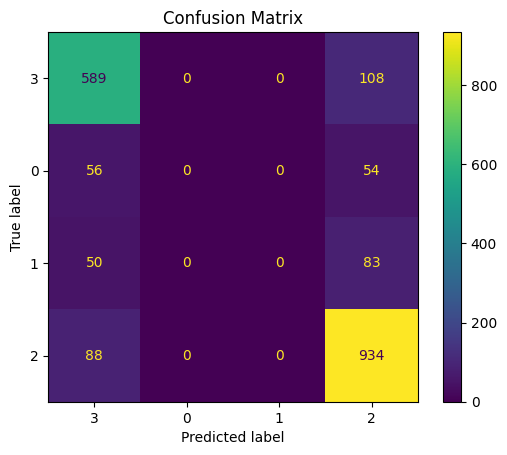

Evaluation Metrics:


{'eval_loss': 0.7205808162689209, 'eval_accuracy': 0.7762487257900101, 'eval_precision': 0.679884249016933, 'eval_recall': 0.7762487257900101, 'eval_f1': 0.7248475898588025, 'eval_runtime': 7.6547, 'eval_samples_per_second': 256.313, 'eval_steps_per_second': 32.137, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
import matplotlib.pyplot as plt

predictions = trainer.predict(dataset["test"])

# Get the predicted labels and true labels
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['label'].unique())
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Additionally, we can print out the computed metrics from the evaluation step
print("Evaluation Metrics:")
print(trainer.evaluate())

In [ ]:
user_text = input("Enter a customer review: ")
label, conf = predict_sentiment(user_text)
print(f"Predicted Sentiment: {label} (Confidence(Probability): {conf:.2f})")
